In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler

%matplotlib inline

In [2]:
def get_confusion_matrix(cm, labels):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [3]:
df = pd.read_csv("./data/fights_cleaned.csv", delimiter=";")
df.shape

(4878, 158)

In [4]:
print(df.loc[:4000,"WINNER"].value_counts())
print(df.loc[4000:,"WINNER"].value_counts())

red        2256
blue       1672
draw/NC      73
Name: WINNER, dtype: int64
red        754
blue       115
draw/NC      9
Name: WINNER, dtype: int64


In [5]:
# due to rarity of draws it will not be considered, so we have a binary classification problem
df = df[df["WINNER"]!="draw/NC"]

- Apparently, in the early fights of the UFC, the red-blue concept was not yet introduced, so the website probably assigned the winner to the red color.
- This should be taken into account as it changes the base prediction
- possible solutions could be oversampling of the "blue-Winner"-population

### Fit simple Random Forest
- data is not normalized

In [6]:
y = df['WINNER']
X = df.drop(columns = ['WINNER','FIGHTER_R','FIGHTER_B'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

In [7]:
clf_1  = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)

In [8]:
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_test)

clf_1.oob_score_

0.6812993854258121

In [9]:
print("RandomForrest accuracy: ", accuracy_score(y_test, y_pred))
print("Baseline accuracy: ", accuracy_score(y_test, ["red"]*len(y_test)))

RandomForrest accuracy:  0.7458333333333333
Baseline accuracy:  0.6625


In [10]:
feature_scores = pd.Series(clf_1.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):
display(feature_scores)

LOSS_PRE_UFC_B    0.022985
WIN_PRE_UFC_R     0.022775
DRAW_PRE_UFC_R    0.020792
DRAW_PRE_UFC_B    0.015159
LOSS_PRE_UFC_R    0.014105
                    ...   
OPEN_STANCE_B     0.000011
OTHER_B           0.000000
OTHER_R           0.000000
SIDEWAYS_B        0.000000
SIDEWAYS_R        0.000000
Length: 155, dtype: float64

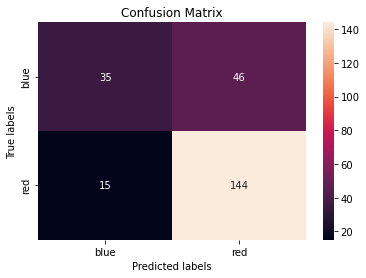

In [11]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
labels = unique_labels(y_test, y_pred)

get_confusion_matrix(conf_matrix,labels)

### Oversampling

In [12]:
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.05, random_state=1)

In [14]:
pd.Series(y_resampled).value_counts()

red     3009
blue    3009
Name: WINNER, dtype: int64

In [15]:
clf_2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)

In [16]:
clf_2.fit(X_train, y_train)
y_pred = clf_2.predict(X_test)

clf_2.oob_score_

0.8131887353507085

In [17]:
print("RandomForrest accuracy: ", accuracy_score(y_test, y_pred))
print("Baseline accuracy: ", accuracy_score(y_test, ["red"]*len(y_test)))

RandomForrest accuracy:  0.840531561461794
Baseline accuracy:  0.5548172757475083


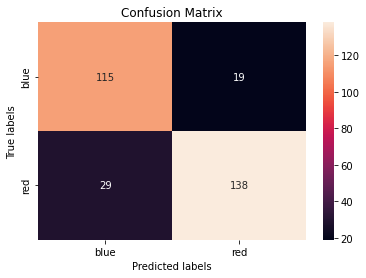

In [18]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
labels = unique_labels(y_test, y_pred)

get_confusion_matrix(conf_matrix,labels)

### Tuning of Hyperparameters

In [36]:
parameters = {
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000, None],
            'max_features': ['sqrt','auto', None]
            }

In [39]:
clf_3 = RandomForestClassifier(random_state=1, n_estimators=1000, criterion='gini')
rf_cv = GridSearchCV(estimator = clf_3, param_grid = parameters, cv=4, n_jobs = -1, verbose=1 #,n_iter=10
                        )
rf_cv.fit(X_train, y_train)

Fitting 4 folds for each of 39 candidates, totalling 156 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=1000,
                                              random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       500, 1000, None],
                         'max_features': ['sqrt', 'auto', None]},
             verbose=1)

In [45]:
rf_cv.best_params_

{'max_depth': 30, 'max_features': None}

In [52]:
with open("./output/random_forest_params", "w") as f:
    json.dump(rf_cv.best_params_, f, indent=4)

In [46]:
clf_3 = rf_cv.best_estimator_

In [47]:
y_3_preds = clf_3.predict(X_test)
accuracy_score(y_test, y_3_preds)

0.8803986710963455

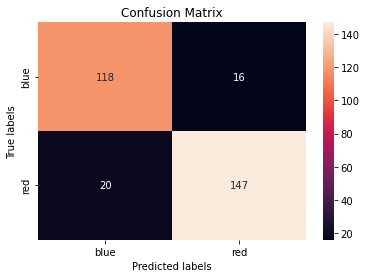

In [49]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_3_preds)
labels = unique_labels(y_test, y_3_preds)

get_confusion_matrix(conf_matrix,labels)

In [48]:
print(classification_report(y_test, y_3_preds))

              precision    recall  f1-score   support

        blue       0.86      0.88      0.87       134
         red       0.90      0.88      0.89       167

    accuracy                           0.88       301
   macro avg       0.88      0.88      0.88       301
weighted avg       0.88      0.88      0.88       301

